# Libraries

In [414]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import os
import re
import random

# Data cleaning

## French museums visitors

In [415]:
#import file about the french museums visitors

visitors=pd.read_csv('Data_sources/frequentation-des-musees-de-france.csv', sep=';', encoding='UTF8')
visitors.head()

,REF DU MUSEE,NOM DU MUSEE,Année,REGION,VILLE,DATE APPELLATION,PAYANT,GRATUIT,TOTAL,Note,ID MUSEOFILE,NOMDEP,Observations
0,8109903,Musée de l'Abbaye Saint-Michel,2009,MIDI-PYRENEES,GAILLAC,01/02/2003,2613.0,669.0,3282.0,NaN,NaN,TARN,NaN
1,8114501,Musée Raymond Lafage,2009,MIDI-PYRENEES,LISLE-SUR-TARN,01/02/2003,1898.0,4429.0,6327.0,NaN,NaN,TARN,NaN
2,5904301,Musée Benoît de Puydt,2009,NORD-PAS-DE-CALAIS,BAILLEUL,01/02/2003,6590.0,0.0,6590.0,NaN,NaN,NORD,NaN
3,5912202,Musée Diocésain d'Art Sacré,2009,NORD-PAS-DE-CALAIS,CAMBRAI,01/02/2003,NaN,NaN,NaN,F,NaN,NORD,NaN
4,5918303,Musée Portuaire,2009,NORD-PAS-DE-CALAIS,DUNKERQUE,01/02/2003,24543.0,21642.0,46185.0,NaN,NaN,NORD,NaN


### Investigating data

In [416]:
#check the data types

visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23586 entries, 0 to 23585
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   REF DU MUSEE      23586 non-null  object 
 1   NOM DU MUSEE      23586 non-null  object 
 2   Année             23586 non-null  int64  
 3   REGION            23586 non-null  object 
 4   VILLE             23586 non-null  object 
 5   DATE APPELLATION  21578 non-null  object 
 6   PAYANT            20235 non-null  float64
 7   GRATUIT           20219 non-null  float64
 8   TOTAL             20218 non-null  float64
 9   Note              3109 non-null   object 
 10  ID MUSEOFILE      2273 non-null   object 
 11  NOMDEP            23586 non-null  object 
 12  Observations      651 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 2.3+ MB


We can change the data types of PAYANT, GRATUIT, TOTAL since those are floats and can be converted into integers since they are related to the number of visitors in each museum. But first, we should check if there are values equal to 0 or missing values in order to avoid changing the meaning when doing the conversion.

In [417]:
visitors.describe()

,Année,PAYANT,GRATUIT,TOTAL
count,23586.000000,2.023500e+04,2.021900e+04,2.021800e+04
mean,2010.563809,3.224182e+04,2.115216e+04,5.342213e+04
std,5.674973,2.453239e+05,1.168334e+05,3.514434e+05
min,2001.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2006.000000,8.680000e+02,1.150500e+03,4.119000e+03
50%,2011.000000,3.993000e+03,4.414000e+03,1.106100e+04
75%,2015.000000,1.422450e+04,1.371150e+04,2.981000e+04
max,2020.000000,6.676633e+06,4.117897e+06,1.010596e+07


### Drop duplicates

In [418]:
#drop duplicates if any

visitors.drop_duplicates(inplace=True)

### Handling null and missing values

In [419]:
#check the missing values in either one of the columns: PAYANT / GRATUIT / TOTAL

visitors.loc[(visitors['GRATUIT'].isna()) | (visitors['PAYANT'].isna()) | (visitors['TOTAL'].isna())]

,REF DU MUSEE,NOM DU MUSEE,Année,REGION,VILLE,DATE APPELLATION,PAYANT,GRATUIT,TOTAL,Note,ID MUSEOFILE,NOMDEP,Observations
3,5912202,Musée Diocésain d'Art Sacré,2009,NORD-PAS-DE-CALAIS,CAMBRAI,01/02/2003,NaN,NaN,NaN,F,NaN,NORD,NaN
36,5306201,Musée d'Art et d'Archéologie Hôtel Fouquet,2009,PAYS DE LA LOIRE,CHATEAU-GONTIER,01/02/2003,NaN,NaN,NaN,F,NaN,MAYENNE,NaN
37,7207101,Musée Heurteloup-Chevalier,2009,PAYS DE LA LOIRE,CHATEAU-DU-LOIR,01/02/2003,NaN,NaN,NaN,F,NaN,SARTHE,NaN
42,268401,Musée de la Vie Rurale et Forestière,2009,PICARDIE,SAINT-MICHEL-EN-THIERACHE,01/02/2003,NaN,NaN,NaN,F,NaN,AISNE,NaN
58,7921601,Musée des Ruralies- Conservatoire du Machinism...,2009,POITOU-CHARENTES,PRAHECQ,01/02/2003,NaN,NaN,NaN,F,NaN,DEUX-SEVRES,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23563,7207101,Musée Heurteloup-Chevalier,2020,PAYS DE LA LOIRE,CHATEAU-DU-LOIR,01/02/2003,NaN,NaN,NaN,F,M0769,SARTHE,NaN
23566,416601,Musée Archéologique,2020,PROVENCE-ALPES-CÔTE D'AZUR,RIEZ-LA-ROMAINE,01/02/2003,NaN,NaN,NaN,F,M0862,ALPES DE HAUTE PROVENCE,NaN
23570,608809,Musée du Vieux-Logis de Nice,2020,PROVENCE-ALPES-CÔTE D'AZUR,NICE,01/02/2003,NaN,NaN,NaN,F,M0882,ALPES-MARITIMES,NaN
23573,1300106,Musée Paul Arbaud,2020,PROVENCE-ALPES-CÔTE D'AZUR,AIX-EN-PROVENCE,01/02/2003,NaN,NaN,NaN,F,M0899,BOUCHES DU RHONE,NaN


In [420]:
#check the values equal to 0 in all the 3 columns: PAYANT / GRATUIT / TOTAL

visitors.loc[(visitors['GRATUIT'] == 0) & (visitors['PAYANT'] == 0) & (visitors['TOTAL'] == 0)]

,REF DU MUSEE,NOM DU MUSEE,Année,REGION,VILLE,DATE APPELLATION,PAYANT,GRATUIT,TOTAL,Note,ID MUSEOFILE,NOMDEP,Observations
4430,3726104,Musée dU Vin de Touraine,2019,CENTRE-VAL DE LOIRE,TOURS,01/02/2003,0.0,0.0,0.0,NaN,M0267,INDRE ET LOIRE,NaN
8926,3808201,Musée - Parc Archéologique du Lac de Paladru,2019,AUVERGNE-RHONE-ALPES,CHARAVINES,01/02/2003,0.0,0.0,0.0,NaN,M1187,ISERE,NaN
9010,238101,Musée - Centre de Documentation Alfred Desmasures,2019,HAUTS-DE-France,HIRSON,01/02/2003,0.0,0.0,0.0,NaN,M0788,AISNE,NaN
13524,3815101,Musée Géo-Charles,2019,AUVERGNE-RHONE-ALPES,ECHIROLLES,01/02/2003,0.0,0.0,0.0,NaN,M0992,ISERE,NaN
16354,1038701,Muséum d'Histoire Naturelle (Musée Pic Saint-L...,2002,CHAMPAGNE-ARDENNES,TROYES,NaN,0.0,0.0,0.0,NaN,NaN,AUBE,1038701 ; 1038704
17196,1038702,Musée Vauluisant - Musée Historique de Troyes ...,2002,CHAMPAGNE-ARDENNES,TROYES,NaN,0.0,0.0,0.0,NaN,NaN,AUBE,1038702 ; 1038703
23455,9109701,Musée Dunoyer de Segonzac,2020,ILE-DE-France,BOUSSY-SAINT-ANTOINE,01/02/2003,0.0,0.0,0.0,NaN,M0402,ESSONNE,NaN


In [421]:
#since the combination of the missing values in either one of the columns and the values equal to 0 in all the 3 columns represent 3387 rows over 23586 rows, I will drop these rows

visitors.drop(visitors.loc[(visitors['GRATUIT'].isna()) | (visitors['PAYANT'].isna()) | (visitors['TOTAL'].isna())].index, inplace=True)

### Change data types

In [422]:
#change the data types from float to integers

visitors['PAYANT']=visitors['PAYANT'].astype(int)
visitors['GRATUIT']=visitors['GRATUIT'].astype(int)
visitors['TOTAL']=visitors['TOTAL'].astype(int)

In [423]:
visitors.isna().sum()

REF DU MUSEE            0
NOM DU MUSEE            0
Année                   0
REGION                  0
VILLE                   0
DATE APPELLATION     1810
PAYANT                  0
GRATUIT                 0
TOTAL                   0
Note                20206
ID MUSEOFILE        18284
NOMDEP                  0
Observations        19815
dtype: int64

There is a lot of missing values regarding the columns: DATE APPELLATION, PAYANT, GRATUIT, TOTAL, Note, ID MUSEOFILE, Observations

### Dropping columns

In [424]:
#drop the columns that won't be used (and that contain too many missing values)

visitors.drop(columns=['DATE APPELLATION', 'Note', 'Observations'], inplace=True)

## French museums info

In [425]:
#import file about the french museums infos

museums=pd.read_csv('Data_sources/liste_des_musees_franciliens.csv', sep=';', encoding='UTF8')
museums.head()

,Région administrative,Département,Identifiant Muséofile,Commune,Nom officiel du musée,Adresse,Lieu,Code Postal,Téléphone,URL,Latitude,Longitude,REF_Deps,geolocalisation,Date arrêté attribution appellation
0,Île-de-France,Hauts-de-Seine,M0411,Issy-les-Moulineaux,musée français de la carte à jouer et galerie ...,"16, rue Auguste Gervais",NaN,92130,01 41 23 83 60,www.museecarteajouer.com/,48.822771,2.273453,9204001.0,"48.822771, 2.273453",01/02/2003
1,Île-de-France,Hauts-de-Seine,M0413,Neuilly-sur-Seine,musée des automates,12 rue du centre,NaN,92200,01 47 45 29 40,www.neuillysurseine.fr/details-d-un-acteur?id=240,48.879608,2.252754,9205101.0,"48.879608, 2.252754",01/02/2003
2,Île-de-France,Hauts-de-Seine,M5019,Sèvres,musée national de la céramique,Place de la Manufacture,NaN,92310,01 46 29 38 01,NaN,48.817037,2.205733,9207201.0,"48.817037, 2.205733",06/01/2002
3,Île-de-France,Paris,M1114,Paris,maison de Victor Hugo,6 place des Vosges,Hôtel de Rohan-Guéménée,75004,01 42 72 10 16,www.maisonsvictorhugo.paris.fr/,48.854808,2.366232,7510405.0,"48.854808, 2.366232",08/07/2004
4,Île-de-France,Paris,M1104,Paris,musée Carnavalet - histoire de Paris,"23, rue de Sévigné",Hôtel Carnavalet,75003,01 44 59 58 58,www.carnavalet.paris.fr/,48.856990,2.362856,7510307.0,"48.85699, 2.362856",08/07/2004


### Investigating data

In [426]:
#check the data types

museums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Région administrative                133 non-null    object 
 1   Département                          133 non-null    object 
 2   Identifiant Muséofile                133 non-null    object 
 3   Commune                              133 non-null    object 
 4   Nom officiel du musée                133 non-null    object 
 5   Adresse                              125 non-null    object 
 6   Lieu                                 63 non-null     object 
 7   Code Postal                          133 non-null    int64  
 8   Téléphone                            126 non-null    object 
 9   URL                                  126 non-null    object 
 10  Latitude                             133 non-null    float64
 11  Longitude                       

In [427]:
museums.describe()

,Code Postal,Latitude,Longitude,REF_Deps
count,133.000000,133.000000,133.000000,1.300000e+02
mean,82029.932331,48.473681,2.697111,8.171023e+06
std,8239.034049,4.023792,4.051750,7.981958e+05
min,75001.000000,2.449719,1.719901,7.510102e+06
25%,75015.000000,48.808966,2.234894,7.510903e+06
50%,77580.000000,48.858133,2.323672,7.733302e+06
75%,92150.000000,48.878849,2.393807,9.202027e+06
max,95500.000000,49.112285,48.986516,9.550002e+06


In [428]:
museums.isna().sum()

Région administrative                   0
Département                             0
Identifiant Muséofile                   0
Commune                                 0
Nom officiel du musée                   0
Adresse                                 8
Lieu                                   70
Code Postal                             0
Téléphone                               7
URL                                     7
Latitude                                0
Longitude                               0
REF_Deps                                3
geolocalisation                         0
Date arrêté attribution appellation     0
dtype: int64

### Drop duplicates

In [429]:
#drop duplicates if any

museums.drop_duplicates(inplace=True)

### Handling missing values

In [430]:
museums.isna().sum()

Région administrative                   0
Département                             0
Identifiant Muséofile                   0
Commune                                 0
Nom officiel du musée                   0
Adresse                                 8
Lieu                                   70
Code Postal                             0
Téléphone                               7
URL                                     7
Latitude                                0
Longitude                               0
REF_Deps                                3
geolocalisation                         0
Date arrêté attribution appellation     0
dtype: int64

There are only 8 missing values regarding the address of the museums, so I will have a look for them and fill them in manually.

In [431]:
#identifying the 8 addresses missing

museums.loc[museums['Adresse'].isna()]

,Région administrative,Département,Identifiant Muséofile,Commune,Nom officiel du musée,Adresse,Lieu,Code Postal,Téléphone,URL,Latitude,Longitude,REF_Deps,geolocalisation,Date arrêté attribution appellation
8,Île-de-France,Paris,M5030,Paris (1er),musée de l'Orangerie des Tuileries,NaN,Jardin des Tuileries,75001,01 40 20 67 71,www.musee-orangerie.fr/,48.868053,2.326622,7510103.0,"48.868053, 2.326622",06/01/2002
31,Île-de-France,Yvelines,M5077,Versailles,musée national des châteaux de Versailles et d...,NaN,Château de Versailles,78000,01 30 83 78 00,www.chateauversailles.fr/,48.804537,2.134053,7864602.0,"48.804537, 2.134053",06/01/2002
39,Île-de-France,Paris,M5051,Paris,musée de l'Ecole nationale supérieure des beau...,NaN,NaN,75006,NaN,beauxartsparis.fr/fr/collection/presentation,48.845748,2.331670,7510610.0,"48.845748, 2.33167",10/07/2017
40,Île-de-France,Paris,M0365,Paris,musée de l'institut du monde arabe,NaN,NaN,75005,NaN,www.imarabe.org/fr/musee/presentation-du-musee,48.843955,2.352176,7510519.0,"48.843955, 2.352176",21/03/2011
54,Île-de-France,Yvelines,M0393,Poissy,musée d'art et d'histoire,NaN,NaN,78300,01 39 22 56 01,musees.ville-poissy.fr/fr/histoire-de-la-colle...,48.927970,2.044648,7849802.0,"48.92797, 2.044648",01/02/2003
90,Île-de-France,Hauts-de-Seine,M1170,Boulogne-Billancourt,musée Paul Belmondo et de la scuplture figurat...,NaN,NaN,92100,NaN,www.boulognebillancourt.com/loisirs/culture/le...,48.834945,2.241177,9201204.0,"48.834945, 2.241177",26/03/2007
97,Île-de-France,Paris,M5084,Paris,musée national de l'histoire et des cultures d...,NaN,NaN,75012,01 53 59 58 60,www.histoire-immigration.fr/,48.836753,2.390394,7511202.0,"48.836753, 2.390394",17/11/2006
110,Île-de-France,Yvelines,M0391,Maule,musée Victor Aubert,NaN,"24, rue Quincampoix",78580,01 30 90 61 49,museeaubertmaule.free.fr/,48.908246,1.847178,7838001.0,"48.908246, 1.847178",01/02/2003


In [432]:
#filling in the addresses for the 4 museums

museums.loc[(museums['Identifiant Muséofile'] == "M5030"), ['Adresse']] = "Jardin des Tuileries"
museums.loc[(museums['Identifiant Muséofile'] == 'M5077'), ['Adresse']] = "Place d'Armes"
museums.loc[(museums['Identifiant Muséofile'] == 'M5051'), ['Adresse']] = "14 rue Bonaparte"
museums.loc[(museums['Identifiant Muséofile'] == 'M0365'), ['Adresse']] = "1, rue des Fossés-Saint-Bernard, Place Mohammed-V"
museums.loc[(museums['Identifiant Muséofile'] == 'M0393'), ['Adresse']] = "12, Rue Saint-Louis"
museums.loc[(museums['Identifiant Muséofile'] == 'M1170'), ['Adresse']] = "14 Rue de l'Abreuvoir"
museums.loc[(museums['Identifiant Muséofile'] == "M5084"), ['Adresse']] = "293 Av. Daumesnil"
museums.loc[(museums['Identifiant Muséofile'] == "M0391"), ['Adresse']] = "24 Rue Quincampoix"

### Dropping columns

In [433]:
#drop the columns that won't be used

museums.drop(columns=['Date arrêté attribution appellation'], inplace=True)

## Parisian exhibitions

In [587]:
#import file about the french museums infos

Paris_exhibitions=pd.read_csv('Data_sources/que-faire-a-paris.csv', sep=';', encoding='UTF8')
Paris_exhibitions.head()

,ID,URL,Titre,Chapeau,Description,Date de début,Date de fin,Occurrences,Description de la date,URL de l'image,...,Unnamed: 189,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198
0,34155,https://www.paris.fr/evenements/baila-babibou-...,"Baila Babibou : spectacle danse & musique, dès...",Baila Babibou propose un dialogue entre une mé...,<p>La danseuse démarre le spectacle en chrysal...,2023-06-21T13:30:00+02:00,2023-06-21T14:00:00+02:00,2023-06-21T11:30:00+02:00_2023-06-21T12:00:00+...,Le mercredi 21 juin 2023<br />de 10h30 à 11h00...,https://cdn.paris.fr/qfapv4/2023/03/17/huge-06...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34268,https://www.paris.fr/evenements/le-fil-des-noe...,Le fil des nœuds,Exposition collective de La.ima du 10 juin au ...,<p>Qu'y a-t-il au-delà de la peau qui cache la...,2023-06-10T02:00:00+02:00,2023-07-09T01:59:59+02:00,NaN,Du samedi 10 juin 2023 au samedi 08 juillet 20...,https://cdn.paris.fr/qfapv4/2023/03/19/huge-04...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34245,https://www.paris.fr/evenements/parcours-d-int...,Parcours d’intellectuels en exil : un humanism...,Un cycle de 4 conférences dédié aux trajectoir...,<p>L’exil n’a jamais épargné les intellectuels...,2023-03-28T02:00:00+02:00,2023-06-14T01:59:59+02:00,NaN,Du mardi 28 mars 2023 au mardi 13 juin 2023 : ...,https://cdn.paris.fr/qfapv4/2023/03/18/huge-e3...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33666,https://www.paris.fr/evenements/concert-java-m...,"Concert : Java, musique du pays Sunda",Venez découvrir la musique du pays Sunda de l'...,"<p>Basé à Paris, <strong>Gamelan Degung Sora G...",2023-05-26T22:00:00+02:00,2023-05-27T00:00:00+02:00,2023-05-26T20:00:00+02:00_2023-05-26T22:00:00+...,Le vendredi 26 mai 2023<br />de 19h00 à 21h00<...,https://cdn.paris.fr/qfapv4/2023/03/09/huge-7f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34251,https://www.paris.fr/evenements/p-tit-dej-litt...,P'tit-Déj' Littéraire,Les bibliothécaires vous lisent leurs derniers...,"<p>Depuis quelques éditions, cette animation e...",2023-06-10T13:30:00+02:00,2023-06-10T15:00:00+02:00,2023-06-10T11:30:00+02:00_2023-06-10T13:00:00+...,Le samedi 10 juin 2023<br />de 10h30 à 12h00<b...,https://cdn.paris.fr/qfapv4/2023/03/04/huge-a3...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Investigating data

In [435]:
Paris_exhibitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077 entries, 0 to 2076
Columns: 199 entries, ID to Unnamed: 198
dtypes: float64(8), object(191)
memory usage: 3.2+ MB


In [436]:
#pd.set_option('display.max_rows', None) -> Note: I used this option in order to see all the 199 columns

Paris_exhibitions.isna().sum()

ID                 0
URL                0
Titre              0
Chapeau            5
Description       19
                ... 
Unnamed: 194    2077
Unnamed: 195    2076
Unnamed: 196    2076
Unnamed: 197    2077
Unnamed: 198    2076
Length: 199, dtype: int64

In [437]:
Paris_exhibitions.describe()

,Unnamed: 177,Unnamed: 178,Unnamed: 180,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 197
count,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,188406340.0,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,188406340.0,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,188406340.0,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,188406340.0,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,188406340.0,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,188406340.0,NaN,NaN,NaN,NaN,NaN


### Drop duplicates

In [588]:
#drop duplicates if any

Paris_exhibitions.drop_duplicates(inplace=True)

### Dropping columns

In [589]:
#remove "Unnamed" columns

Paris_exhibitions = Paris_exhibitions.loc[:, ~Paris_exhibitions.columns.str.contains('^Unnamed')]

In [590]:
#drop columns that won't be used

Paris_exhibitions.drop(columns=['ID', 'Description de la date', "URL de l'image", "Texte alternatif de l'image", "Crédit de l'image", 'Accès PMR', 'Accès mal voyant', 'Accès mal entendant', 'Transport', 'Url de contact', 'Téléphone de contact', 'Email de contact', 'En ligne - address_url', 'En ligne - address_url_text', 'En ligne - address_text', 'title_event', 'childrens', 'URL Facebook associée', 'URL Twitter associée', 'URL de réservation', 'URL de réservation - Texte', 'Programmes', 'Détail du prix', 'Occurrences', 'Description de la date', "URL de l'image", "Type d'accès", "Date de mise à jour", "Image de couverture", "contributor_group"], inplace=True)

### Handling missing values

In [441]:
#check the missing values

Paris_exhibitions.isna().sum()

URL                            0
Titre                          0
Chapeau                        5
Description                   19
Date de début                 56
Date de fin                   56
Mots clés                     52
Nom du lieu                  132
Adresse du lieu              129
Code postal                  129
Ville                        129
Coordonnées géographiques     81
Type de prix                  10
audience                       6
dtype: int64

In [442]:
len(Paris_exhibitions)

2077

In [591]:
#since our dataframe contains 2077 rows, we can drop the missing values identified above

Paris_exhibitions = Paris_exhibitions.dropna()

### Change data types

In [646]:
#change the dates to datetime format

Paris_exhibitions['Date de fin'] = pd.to_datetime(Paris_exhibitions['Date de fin'])
Paris_exhibitions['Date de début'] = pd.to_datetime(Paris_exhibitions['Date de début'])

### Exhibitions keywords analysis & cleaning

In [444]:
Paris_exhibitions['Mots clés'].unique()

array(['Danse,Enfants,Spectacle musical', 'Art contemporain,Expo,Photo',
       'Conférence,Littérature,Sciences', 'Concert,Musique',
       'Littérature', 'Expo,Street-art', 'Expo', 'Cirque,Conférence',
       'Enfants,Musique,Spectacle musical', 'Atelier', 'Atelier,Peinture',
       'Atelier,Cinéma,Photo', 'Conférence,Histoire,Sport',
       'Art contemporain,Expo,Peinture',
       'Concert,Musique,Spectacle musical', 'Atelier,Enfants,Nature',
       'Atelier,Danse,Solidarité', 'Jeux 2024,Sport',
       'Spectacle musical,Street-art,Théâtre', 'Atelier,Enfants,Loisirs',
       'Expo,Histoire,Photo', 'Atelier,Enfants',
       'Atelier,Enfants,Innovation', 'Cinéma', 'Atelier,Loisirs,Nature',
       'Conférence', 'Art contemporain,installation', 'musique',
       'installation,musique', 'Enfants,Théâtre', 'Art contemporain,Expo',
       'Art contemporain,Expo,Nature', 'Art contemporain,exposition',
       'Art contemporain,Spectacle musical',
       '2023-12-15T13:30:47+01:00_2023-12-15T

In [592]:
#since there are dates instead of real key words for describing exhibitions, we're gonna have a look at these records

Paris_exhibitions.loc[Paris_exhibitions['Mots clés'].str.startswith('2')]

,URL,Titre,Chapeau,Description,Date de début,Date de fin,Mots clés,Nom du lieu,Adresse du lieu,Code postal,Ville,Coordonnées géographiques,Type de prix,audience
49,2023-11-30T13:30:47+01:00_2023-11-30T18:00:47+...,2023-12-01T13:30:47+01:00_2023-12-01T18:00:47+...,2023-12-02T13:30:47+01:00_2023-12-02T18:00:47+...,2023-12-03T13:30:47+01:00_2023-12-03T18:00:47+...,2023-12-06T13:30:47+01:00_2023-12-06T18:00:47+...,2023-12-07T13:30:47+01:00_2023-12-07T18:00:47+...,2023-12-15T13:30:47+01:00_2023-12-15T18:00:47+...,2023-12-16T13:30:47+01:00_2023-12-16T18:00:47+...,2023-12-17T13:30:47+01:00_2023-12-17T18:00:47+...,2023-12-20T13:30:47+01:00_2023-12-20T18:00:47+...,2023-12-21T13:30:47+01:00_2023-12-21T18:00:47+...,2023-12-22T13:30:47+01:00_2023-12-22T18:00:47+...,Voute sculptée de l'escalier princier de la to...,http://www.tourjeansanspeur.com
672,2023-11-17T10:00:03+01:00_2023-11-17T17:00:03+...,2023-11-18T10:00:03+01:00_2023-11-18T17:00:03+...,2023-11-18T10:00:03+01:00_2023-11-18T17:00:03+...,2023-11-19T10:00:03+01:00_2023-11-19T17:00:03+...,2023-11-19T10:00:03+01:00_2023-11-19T17:00:03+...,2023-11-20T10:00:03+01:00_2023-11-20T17:00:03+...,2023-11-23T10:00:03+01:00_2023-11-23T17:00:03+...,2023-11-23T10:00:03+01:00_2023-11-23T17:00:03+...,2023-11-24T10:00:03+01:00_2023-11-24T17:00:03+...,2023-11-24T10:00:03+01:00_2023-11-24T17:00:03+...,2023-11-25T10:00:03+01:00_2023-11-25T17:00:03+...,2023-11-25T10:00:03+01:00_2023-11-25T17:00:03+...,2023-11-30T10:00:03+01:00_2023-11-30T17:00:03+...,2023-12-06T10:00:03+01:00_2023-12-06T17:00:03+...
1192,2023-06-08T11:00:54+02:00_2023-06-08T14:00:54+...,2023-06-09T11:00:54+02:00_2023-06-09T14:00:54+...,2023-06-10T10:30:54+02:00_2023-06-10T19:00:54+...,2023-06-11T10:30:54+02:00_2023-06-11T19:00:54+...,2023-06-13T11:00:54+02:00_2023-06-13T14:00:54+...,2023-06-15T11:00:54+02:00_2023-06-15T14:00:54+...,2023-06-23T11:00:54+02:00_2023-06-23T14:00:54+...,2023-06-24T10:30:54+02:00_2023-06-24T19:00:54+...,2023-06-25T10:30:54+02:00_2023-06-25T19:00:54+...,2023-06-27T11:00:54+02:00_2023-06-27T14:00:54+...,2023-06-29T11:00:54+02:00_2023-06-29T14:00:54+...,2023-06-30T11:00:54+02:00_2023-06-30T14:00:54+...,2023-07-14T11:00:54+02:00_2023-07-14T14:00:54+...,2023-07-30T10:30:54+02:00_2023-07-30T19:00:54+...
1553,2023-07-21T12:00:00+02:00_2023-07-21T21:00:00+...,2023-07-22T12:00:00+02:00_2023-07-22T21:00:00+...,2023-07-23T12:00:00+02:00_2023-07-23T21:00:00+...,2023-07-24T12:00:00+02:00_2023-07-24T21:00:00+...,2023-07-25T12:00:00+02:00_2023-07-25T21:00:00+...,2023-07-26T12:00:00+02:00_2023-07-26T21:00:00+...,2023-08-01T12:00:00+02:00_2023-08-01T21:00:00+...,2023-08-02T12:00:00+02:00_2023-08-02T21:00:00+...,2023-08-03T12:00:00+02:00_2023-08-03T21:00:00+...,2023-08-04T12:00:00+02:00_2023-08-04T21:00:00+...,2023-08-05T12:00:00+02:00_2023-08-05T21:00:00+...,2023-08-06T12:00:00+02:00_2023-08-06T21:00:00+...,2023-08-16T12:00:00+02:00_2023-08-16T21:00:00+...,2023-08-28T12:00:00+02:00_2023-08-28T21:00:00+...


In [593]:
#these records don't add any values so we're gonna remove them

Paris_exhibitions.drop(Paris_exhibitions.loc[Paris_exhibitions['Mots clés'].str.startswith('2')].index, inplace=True)

In [594]:
Paris_exhibitions.dropna(subset=['Mots clés'], inplace=True)

### Adding a duration column

For further analysis, we're gonna add a duration column computed based on the exhibition start date and end date.

In [648]:
Paris_exhibitions['durée'] = Paris_exhibitions['Date de fin'] - Paris_exhibitions['Date de début'] #computing the difference between the start and end date
Paris_exhibitions['durée'] = Paris_exhibitions['durée'].dt.days #returning the duration in days
Paris_exhibitions

,URL,Titre,Chapeau,Description,Date de début,Date de fin,Mots clés,Nom du lieu,Adresse du lieu,Code postal,Ville,Coordonnées géographiques,Type de prix,audience,durée,Month,Date,first_element
0,https://www.paris.fr/evenements/baila-babibou-...,"Baila Babibou : spectacle danse & musique, dès...",Baila Babibou propose un dialogue entre une mé...,<p>La danseuse démarre le spectacle en chrysal...,2023-06-21 13:30:00+02:00,2023-06-21 14:00:00+02:00,"Danse,Enfants,Spectacle musical",Bibliothèque Jacqueline de Romilly,16 avenue de la Porte Montmartre,75018,Paris,"48.8994220173449, 2.33641997088512",gratuit,Public enfants. A partir de 1 ans. Jusqu'à 7 ans.,0,2023-06-21 13:30:00+02:00,"[2023-06-21, 13:30:00+02:00]",2023-06-21
1,https://www.paris.fr/evenements/le-fil-des-noe...,Le fil des nœuds,Exposition collective de La.ima du 10 juin au ...,<p>Qu'y a-t-il au-delà de la peau qui cache la...,2023-06-10 02:00:00+02:00,2023-07-09 01:59:59+02:00,"Art contemporain,Expo,Photo",Médiathèque Edmond Rostand,11 rue Nicolas Chuquet,75017,Paris,"48.8883939892465, 2.30309000346023",gratuit,Public adolescents adultes.,28,2023-06-10 02:00:00+02:00,"[2023-06-10, 02:00:00+02:00]",2023-06-10
2,https://www.paris.fr/evenements/parcours-d-int...,Parcours d’intellectuels en exil : un humanism...,Un cycle de 4 conférences dédié aux trajectoir...,<p>L’exil n’a jamais épargné les intellectuels...,2023-03-28 02:00:00+02:00,2023-06-14 01:59:59+02:00,"Conférence,Littérature,Sciences",Fondation Maison des sciences de l'homme,54 boulevard Raspail,75006,Paris,"48.8502890192206, 2.32696501646515",gratuit,Public adolescents adultes.,77,2023-03-28 02:00:00+02:00,"[2023-03-28, 02:00:00+02:00]",2023-03-28
3,https://www.paris.fr/evenements/concert-java-m...,"Concert : Java, musique du pays Sunda",Venez découvrir la musique du pays Sunda de l'...,"<p>Basé à Paris, <strong>Gamelan Degung Sora G...",2023-05-26 22:00:00+02:00,2023-05-27 00:00:00+02:00,"Concert,Musique",Médiathèque Marguerite Yourcenar,"41, rue d'Alleray",75015,Paris,"48.83680697942, 2.30348101924335",gratuit,Tout public.,0,2023-05-26 22:00:00+02:00,"[2023-05-26, 22:00:00+02:00]",2023-05-26
4,https://www.paris.fr/evenements/p-tit-dej-litt...,P'tit-Déj' Littéraire,Les bibliothécaires vous lisent leurs derniers...,"<p>Depuis quelques éditions, cette animation e...",2023-06-10 13:30:00+02:00,2023-06-10 15:00:00+02:00,Littérature,Médiathèque Marguerite Yourcenar,"41, rue d'Alleray",75015,Paris,"48.83680697942, 2.30348101924335",gratuit,Public adolescents adultes.,0,2023-06-10 13:30:00+02:00,"[2023-06-10, 13:30:00+02:00]",2023-06-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,https://www.paris.fr/evenements/projection-du-...,"Projection du film ""Icare"", accessible aux sou...",Venez profiter d'une projection gratuite du fi...,"<p>Dans le cadre du Quartier du livre 2023, le...",2023-06-04 13:45:00+02:00,2023-06-04 15:00:00+02:00,"Cinéma,Loisirs",Studio des Ursulines,10 rue des Ursulines,75005,Paris,"48.8427279977327, 2.3420599858938",gratuit,Tout public.,0,2023-06-04 13:45:00+02:00,"[2023-06-04, 13:45:00+02:00]",2023-06-04
2073,https://www.paris.fr/evenements/bhlm-2023-la-l...,BHLM 2023 : La lecture prend l'air !,C’est l’été ! À partir du 13 juillet et jusqu'...,<p>Profitez d'un moment de détente estival ave...,2023-07-13 18:30:00+02:00,2023-08-10 20:00:00+02:00,Loisirs,Bibliothèque Aimé Césaire,5 rue de Ridder,75014,Paris,"48.8312310021516, 2.31166200819968",gratuit,Tout public.,28,2023-07-13 18:30:00+02:00,"[2023-07-13, 18:30:00+02:00]",2023-07-13
2074,https://www.paris.fr/evenements/mona-and-frien...,Mona and Friends,"Bossa, standards et swing au Melville avec la ...","<p>Mona Faruel, jeune chanteuse du conservatoi...",2023-07-01 00:00:00+02:00,2023-07-01 02:00:00+02:00,"Concert,Musique",Le Melville,28 Rue Jean Mermoz,75008,Paris,"48.8713718, 2.3121803",gratuit,Public adolescents adultes.,0,2023-07-01 00:00:00+02:00,"[2023-07-01, 00:00:00+02:00]",2023-07-01
2075,https://www.p

In [643]:
#A ENLEVER

# Paris_exhibitions['Date de début'].date.dt.strftime('%m')
# Paris_exhibitions['Date']=pd.to_datetime(Paris_exhibitions['Date de début'])
# Paris_exhibitions['Date']=Paris_exhibitions['Date de début'].astype(str)
# Paris_exhibitions['Date']=Paris_exhibitions['Date'].str.split('T')
# Paris_exhibitions['first_element']=Paris_exhibitions['Date'].apply(lambda x: x[0])
# len(Paris_exhibitions.loc[Paris_exhibitions['first_element'] == "2023-06-03"])


# list = []

# for i in Paris_exhibitions['Date']:
#    list.append


# Paris_exhibitions['ConvertedDate'] = Paris_exhibitions['Date'].dt.strftime('%m/%d/%Y')
# Paris_exhibitions['Date'].dt.strftime('%m/%d/%Y')
# Paris_exhibitions['Jour']=Paris_exhibitions['Date de début'].dt.month_name

266

## Merging french museums visitors & infos

This will allow us to have a dataframe that combines information regarding the museums (e.g. latitude, longitude) as well as the number of visitors for each museum.

In [449]:
Paris_museums = visitors.merge(museums, left_on="ID MUSEOFILE", right_on="Identifiant Muséofile")
Paris_museums.head()

,REF DU MUSEE,NOM DU MUSEE,Année,REGION,VILLE,PAYANT,GRATUIT,TOTAL,ID MUSEOFILE,NOMDEP,...,Nom officiel du musée,Adresse,Lieu,Code Postal,Téléphone,URL,Latitude,Longitude,REF_Deps,geolocalisation
0,9109701,Musée Dunoyer de Segonzac,2019,ILE-DE-France,BOUSSY-SAINT-ANTOINE,0,172,172,M0402,ESSONNE,...,musée Dunoyer de Segonzac,"5, place des Droits de l'Homme",NaN,91800,01 69 00 49 23,www.ville-boussy.fr/votre-mairie/la-culture.html,48.688925,2.530019,9109701.0,"48.688925, 2.530019"
1,9109701,Musée Dunoyer de Segonzac,2020,ILE-DE-France,BOUSSY-SAINT-ANTOINE,0,0,0,M0402,ESSONNE,...,musée Dunoyer de Segonzac,"5, place des Droits de l'Homme",NaN,91800,01 69 00 49 23,www.ville-boussy.fr/votre-mairie/la-culture.html,48.688925,2.530019,9109701.0,"48.688925, 2.530019"
2,9120001,Musée du Château,2019,ILE-DE-France,DOURDAN,4476,6384,10860,M0404,ESSONNE,...,musée du château,Place du général de Gaulle,Château de Dourdan,91410,01 64 59 66 83,www.dourdan.fr/a-voir-a-vivre/lechateauetsonmu...,48.529685,2.011803,9120001.0,"48.529685, 2.011803"
3,9120001,Musée du Château,2020,ILE-DE-France,DOURDAN,9244,0,9244,M0404,ESSONNE,...,musée du château,Place du général de Gaulle,Château de Dourdan,91410,01 64 59 66 83,www.dourdan.fr/a-voir-a-vivre/lechateauetsonmu...,48.529685,2.011803,9120001.0,"48.529685, 2.011803"
4,9202501,Musée Municipal d'Art et d'Histoire,2019,ILE-DE-France,COLOMBES,0,3342,3342,M0409,HAUTS DE SEINE,...,musée municipal d'art et d'histoire,"2, rue Gabriel Péri",NaN,92700,01 47 86 38 85,www.colombes.fr/culture/musee-municipal-d-art-...,48.923321,2.252039,9202501.0,"48.923321, 2.252039"


In [450]:
#creating one dataframe for parisian museums

Paris_museums = Paris_museums.loc[Paris_museums['VILLE'] == 'PARIS']

### Drop duplicates

In [451]:
Paris_museums.drop_duplicates(inplace=True)

### Dropping columns

In [452]:
Paris_museums.isna().sum()

REF DU MUSEE              0
NOM DU MUSEE              0
Année                     0
REGION                    0
VILLE                     0
PAYANT                    0
GRATUIT                   0
TOTAL                     0
ID MUSEOFILE              0
NOMDEP                    0
Région administrative     0
Département               0
Identifiant Muséofile     0
Commune                   0
Nom officiel du musée     0
Adresse                   0
Lieu                     44
Code Postal               0
Téléphone                 6
URL                       0
Latitude                  0
Longitude                 0
REF_Deps                  0
geolocalisation           0
dtype: int64

We could drop the 'Lieu' column since we already have the address, and fill in the 8 addresses missing.
We could also remove the 'Commune' since we already have the 'Code Postal'.
We could also remove either the 'Latitude' and 'Longitude' columns or the 'geolocalisation' one since those two both give the coordinates of the museums.
We should also remove duplicates columns (e.g. NOM DU MUSEE or Nom officiel du musée, REGION or Région administrative, NOMDEP or Département, etc.)

In [453]:
#drop columns that won't be used or that are duplicates

Paris_museums.drop(columns=['Région administrative', 'Département', 'Nom officiel du musée', 'Lieu', 'Commune', 'REF_Deps', 'Téléphone'], inplace=True)

## Merging exhibitions & parisian museums

This will allow us to have a dataframe that combines information regarding the museums (e.g. latitude, longitude) as well as the exhibitions available in Paris.

In [454]:
Paris_exhibitions_museums = Paris_exhibitions.merge(Paris_museums, left_on="Nom du lieu", right_on="NOM DU MUSEE", how='left')
Paris_exhibitions_museums.head()

,URL_x,Titre,Chapeau,Description,Date de début,Date de fin,Mots clés,Nom du lieu,Adresse du lieu,Code postal,...,TOTAL,ID MUSEOFILE,NOMDEP,Identifiant Muséofile,Adresse,Code Postal,URL_y,Latitude,Longitude,geolocalisation
0,https://www.paris.fr/evenements/baila-babibou-...,"Baila Babibou : spectacle danse & musique, dès...",Baila Babibou propose un dialogue entre une mé...,<p>La danseuse démarre le spectacle en chrysal...,2023-06-21T13:30:00+02:00,2023-06-21T14:00:00+02:00,"Danse,Enfants,Spectacle musical",Bibliothèque Jacqueline de Romilly,16 avenue de la Porte Montmartre,75018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.paris.fr/evenements/le-fil-des-noe...,Le fil des nœuds,Exposition collective de La.ima du 10 juin au ...,<p>Qu'y a-t-il au-delà de la peau qui cache la...,2023-06-10T02:00:00+02:00,2023-07-09T01:59:59+02:00,"Art contemporain,Expo,Photo",Médiathèque Edmond Rostand,11 rue Nicolas Chuquet,75017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.paris.fr/evenements/parcours-d-int...,Parcours d’intellectuels en exil : un humanism...,Un cycle de 4 conférences dédié aux trajectoir...,<p>L’exil n’a jamais épargné les intellectuels...,2023-03-28T02:00:00+02:00,2023-06-14T01:59:59+02:00,"Conférence,Littérature,Sciences",Fondation Maison des sciences de l'homme,54 boulevard Raspail,75006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.paris.fr/evenements/concert-java-m...,"Concert : Java, musique du pays Sunda",Venez découvrir la musique du pays Sunda de l'...,"<p>Basé à Paris, <strong>Gamelan Degung Sora G...",2023-05-26T22:00:00+02:00,2023-05-27T00:00:00+02:00,"Concert,Musique",Médiathèque Marguerite Yourcenar,"41, rue d'Alleray",75015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.paris.fr/evenements/p-tit-dej-litt...,P'tit-Déj' Littéraire,Les bibliothécaires vous lisent leurs derniers...,"<p>Depuis quelques éditions, cette animation e...",2023-06-10T13:30:00+02:00,2023-06-10T15:00:00+02:00,Littérature,Médiathèque Marguerite Yourcenar,"41, rue d'Alleray",75015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [455]:
#check the size of the dataframe newly created

len(Paris_exhibitions_museums)

1891

### Drop duplicates

In [456]:
Paris_exhibitions_museums.drop_duplicates(inplace=True)

### Handling missing values and dropping columns

In [457]:
Paris_exhibitions_museums.isna().sum()

URL_x                           0
Titre                           0
Chapeau                         0
Description                     0
Date de début                   0
Date de fin                     0
Mots clés                       0
Nom du lieu                     0
Adresse du lieu                 0
Code postal                     0
Ville                           0
Coordonnées géographiques       0
Type de prix                    0
audience                        0
durée                           0
REF DU MUSEE                 1833
NOM DU MUSEE                 1833
Année                        1833
REGION                       1833
VILLE                        1833
PAYANT                       1833
GRATUIT                      1833
TOTAL                        1833
ID MUSEOFILE                 1833
NOMDEP                       1833
Identifiant Muséofile        1833
Adresse                      1833
Code Postal                  1833
URL_y                        1833
Latitude      

In [458]:
Paris_exhibitions_museums = Paris_exhibitions_museums.loc[Paris_exhibitions_museums["NOM DU MUSEE"].notna()]

In [459]:
#Drop columns that won't be used or that are duplicates

Paris_exhibitions_museums.drop(columns=["REF DU MUSEE", "NOM DU MUSEE", "VILLE", "ID MUSEOFILE", "Identifiant Muséofile", "Adresse", "Code Postal", "URL_y", "Latitude", "Longitude", "geolocalisation"], inplace=True)

### Change data types

In [460]:
#change the data types from float to integers

Paris_exhibitions_museums['Année']=Paris_exhibitions_museums['Année'].astype(int)
Paris_exhibitions_museums['PAYANT']=Paris_exhibitions_museums['PAYANT'].astype(int)
Paris_exhibitions_museums['GRATUIT']=Paris_exhibitions_museums['GRATUIT'].astype(int)
Paris_exhibitions_museums['TOTAL']=Paris_exhibitions_museums['TOTAL'].astype(int)

## Merging parisian exhibitions & museums visitors 

This will allow us to have a dataframe that combines information regarding the exhibitions and the number of visitors in Paris museums.

In [461]:
Paris_exhibitions_visitors = Paris_exhibitions.merge(visitors, left_on="Nom du lieu", right_on="NOM DU MUSEE", how='left')

### Drop duplicates

In [462]:
Paris_exhibitions_visitors.drop_duplicates(inplace=True)

### Handling missing values

In [463]:
Paris_exhibitions_visitors.isna().sum()

URL                             0
Titre                           0
Chapeau                         0
Description                     0
Date de début                   0
Date de fin                     0
Mots clés                       0
Nom du lieu                     0
Adresse du lieu                 0
Code postal                     0
Ville                           0
Coordonnées géographiques       0
Type de prix                    0
audience                        0
durée                           0
REF DU MUSEE                 1830
NOM DU MUSEE                 1830
Année                        1830
REGION                       1830
VILLE                        1830
PAYANT                       1830
GRATUIT                      1830
TOTAL                        1830
ID MUSEOFILE                 2344
NOMDEP                       1830
dtype: int64

In [464]:
len(Paris_exhibitions_visitors)

#since our dataset contains 2408 rows, we can get rid of the missing values

2404

In [465]:
#we keep only the records that do not have missing values in the visitors columns dataset ("NOM DU MUSEE", "REF DU MUSEE", etc.)

Paris_exhibitions_visitors = Paris_exhibitions_visitors.loc[Paris_exhibitions_visitors["NOM DU MUSEE"].notna()]
len(Paris_exhibitions_visitors)

574

We have 574 exhibitions in Paris that contain information about the number of visitors in the related museums.

### Change data types

In [466]:
#change the data types from float to integers

Paris_exhibitions_visitors['Année']=Paris_exhibitions_visitors['Année'].astype(int)
Paris_exhibitions_visitors['PAYANT']=Paris_exhibitions_visitors['PAYANT'].astype(int)
Paris_exhibitions_visitors['GRATUIT']=Paris_exhibitions_visitors['GRATUIT'].astype(int)
Paris_exhibitions_visitors['TOTAL']=Paris_exhibitions_visitors['TOTAL'].astype(int)

### Dropping columns

In [467]:
#We can drop the ID MUSEOFILE since we won't use it anymore

Paris_exhibitions_visitors.drop(columns=['ID MUSEOFILE', 'VILLE'], inplace=True)

In [468]:
Paris_exhibitions_visitors.head()

,URL,Titre,Chapeau,Description,Date de début,Date de fin,Mots clés,Nom du lieu,Adresse du lieu,Code postal,...,audience,durée,REF DU MUSEE,NOM DU MUSEE,Année,REGION,PAYANT,GRATUIT,TOTAL,NOMDEP
23,https://www.paris.fr/evenements/nouveaute-baby...,Nouveauté ! Baby-visite au musée Bourdelle,Profitez d'une visite sensorielle et d'un temp...,<p>Une \nvisite sensorielle et participative a...,2023-05-10T13:30:00+02:00,2023-06-14T14:30:00+02:00,"Atelier,Enfants",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Public enfants adultes.,35,7511502,Musée Bourdelle,2011,ILE-DE-FRANCE,81804,40720,122524,PARIS
24,https://www.paris.fr/evenements/nouveaute-baby...,Nouveauté ! Baby-visite au musée Bourdelle,Profitez d'une visite sensorielle et d'un temp...,<p>Une \nvisite sensorielle et participative a...,2023-05-10T13:30:00+02:00,2023-06-14T14:30:00+02:00,"Atelier,Enfants",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Public enfants adultes.,35,7511502,Musée Bourdelle,2013,ILE-DE-FRANCE,12433,54170,66603,PARIS
25,https://www.paris.fr/evenements/nouveaute-baby...,Nouveauté ! Baby-visite au musée Bourdelle,Profitez d'une visite sensorielle et d'un temp...,<p>Une \nvisite sensorielle et participative a...,2023-05-10T13:30:00+02:00,2023-06-14T14:30:00+02:00,"Atelier,Enfants",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Public enfants adultes.,35,7511502,Musée Bourdelle,2016,ILE-DE-FRANCE,2720,36657,39377,PARIS
26,https://www.paris.fr/evenements/nouveaute-baby...,Nouveauté ! Baby-visite au musée Bourdelle,Profitez d'une visite sensorielle et d'un temp...,<p>Une \nvisite sensorielle et participative a...,2023-05-10T13:30:00+02:00,2023-06-14T14:30:00+02:00,"Atelier,Enfants",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Public enfants adultes.,35,7511502,Musée Bourdelle,2005,ILE-DE-FRANCE,9840,28912,38752,PARIS
27,https://www.paris.fr/evenements/nouveaute-baby...,Nouveauté ! Baby-visite au musée Bourdelle,Profitez d'une visite sensorielle et d'un temp...,<p>Une \nvisite sensorielle et participative a...,2023-05-10T13:30:00+02:00,2023-06-14T14:30:00+02:00,"Atelier,Enfants",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Public enfants adultes.,35,7511502,Musée Bourdelle,2018,ILE-DE-FRANCE,18500,39322,57822,PARIS


## French regions

For clarity purpose, we'll create a french regions dataframe retrieving them from the visitors dataframe.

In [469]:
#based on the visitors dataframe, we'll retrieve the french regions where museums information is available

visitors.head()

,REF DU MUSEE,NOM DU MUSEE,Année,REGION,VILLE,PAYANT,GRATUIT,TOTAL,ID MUSEOFILE,NOMDEP
0,8109903,Musée de l'Abbaye Saint-Michel,2009,MIDI-PYRENEES,GAILLAC,2613,669,3282,NaN,TARN
1,8114501,Musée Raymond Lafage,2009,MIDI-PYRENEES,LISLE-SUR-TARN,1898,4429,6327,NaN,TARN
2,5904301,Musée Benoît de Puydt,2009,NORD-PAS-DE-CALAIS,BAILLEUL,6590,0,6590,NaN,NORD
4,5918303,Musée Portuaire,2009,NORD-PAS-DE-CALAIS,DUNKERQUE,24543,21642,46185,NaN,NORD
5,6210801,Musée Communautaire Opale-Sud,2009,NORD-PAS-DE-CALAIS,BERCK-SUR-MER,2757,7149,9906,NaN,PAS-DE-CALAIS


In [470]:
regions = pd.DataFrame(visitors, columns=['REGION', 'VILLE']) #create a dataframe keeping only the 'REGION' and 'VILLE' columns
regions.drop_duplicates(inplace=True) #remove duplicates

In [471]:
regions

,REGION,VILLE
0,MIDI-PYRENEES,GAILLAC
1,MIDI-PYRENEES,LISLE-SUR-TARN
2,NORD-PAS-DE-CALAIS,BAILLEUL
4,NORD-PAS-DE-CALAIS,DUNKERQUE
5,NORD-PAS-DE-CALAIS,BERCK-SUR-MER
...,...,...
23390,BOURGOGNE-FRANCHE-COMTE,BELFORT cedex
23411,CENTRE-VAL DE LOIRE,PITHIVIERS Cedex
23412,CORSE,BASTIA Cedex
23502,NORMANDIE,FLERS cedex


# Missing values left in each dataframe

For summary purpose:

In [539]:
visitors.isna().sum()

REF DU MUSEE        0
NOM DU MUSEE        0
Année               0
REGION              0
VILLE               0
PAYANT              0
GRATUIT             0
TOTAL               0
ID MUSEOFILE    18284
NOMDEP              0
dtype: int64

In [473]:
museums.isna().sum()

Région administrative     0
Département               0
Identifiant Muséofile     0
Commune                   0
Nom officiel du musée     0
Adresse                   0
Lieu                     70
Code Postal               0
Téléphone                 7
URL                       7
Latitude                  0
Longitude                 0
REF_Deps                  3
geolocalisation           0
dtype: int64

# Exporting cleaned data from Python notebook to the MySQL Workbench

In [474]:
import pymysql.cursors
from sqlalchemy import create_engine, MetaData
from sqlalchemy.schema import CreateTable
from sqlalchemy import text
import getpass

In [475]:
#prompt user to enter MySQL root password

sql_pass = getpass.getpass()

In [476]:
#create connection string and engine to connect to MySQL database

connection_string = 'mysql+pymysql://root:' + sql_pass + '@localhost:3306/exhibitions'
engine = create_engine(connection_string)

In [477]:
visitors.to_sql('visitors', engine, 'exhibitions', if_exists='replace', index=False)

20206

In [478]:
museums.to_sql('museums', engine, 'exhibitions', if_exists='replace', index=False)

133

In [479]:
Paris_exhibitions.to_sql('Paris_exhibitions', engine, 'exhibitions', if_exists='replace', index=False)

1865

In [480]:
Paris_museums.to_sql('Paris_museums', engine, 'exhibitions', if_exists='replace', index=False)


93

In [481]:
Paris_exhibitions_museums.to_sql('Paris_exhibitions_museums', engine, 'exhibitions', if_exists='replace', index=False)


58

In [482]:
Paris_exhibitions_visitors.to_sql('Paris_exhibitions_visitors', engine, 'exhibitions', if_exists='replace', index=False)


574

In [483]:
regions.to_sql('regions', engine, 'exhibitions', if_exists='replace', index=False)


1615

# Exporting cleaned data from Python notebook to Csv

In [484]:
visitors.to_csv("Cleaned_Data/visitors.csv", index=False)

In [485]:
museums.to_csv("Cleaned_Data/museums.csv", index=False)

In [486]:
Paris_exhibitions.to_csv("Cleaned_Data/Paris_exhibitions.csv", index=False)

In [487]:
Paris_museums.to_csv("Cleaned_Data/Paris_museums.csv", index=False)

In [488]:
Paris_exhibitions_museums.to_csv("Cleaned_Data/Paris_exhibitions_museums.csv", index=False)

In [489]:
Paris_exhibitions_visitors.to_csv("Cleaned_Data/Paris_exhibitions_visitors.csv", index=False)

In [490]:
regions.to_csv("Cleaned_Data/regions.csv", index=False)

# Explanatory data analysis

It can be interesting to analyze if there is a correlation between the exhibition's duration and the number of visitors.

In [517]:
#remove the year for our analysis

df = Paris_exhibitions_visitors.drop(columns="Année")

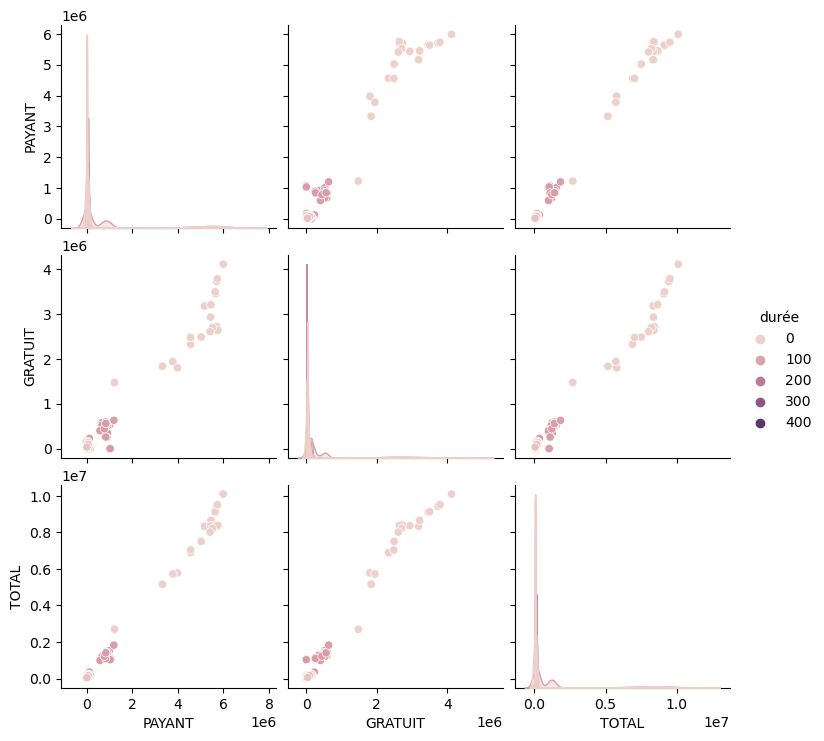

In [665]:
#plot pairwise relationships

sns.pairplot(df, hue="durée");

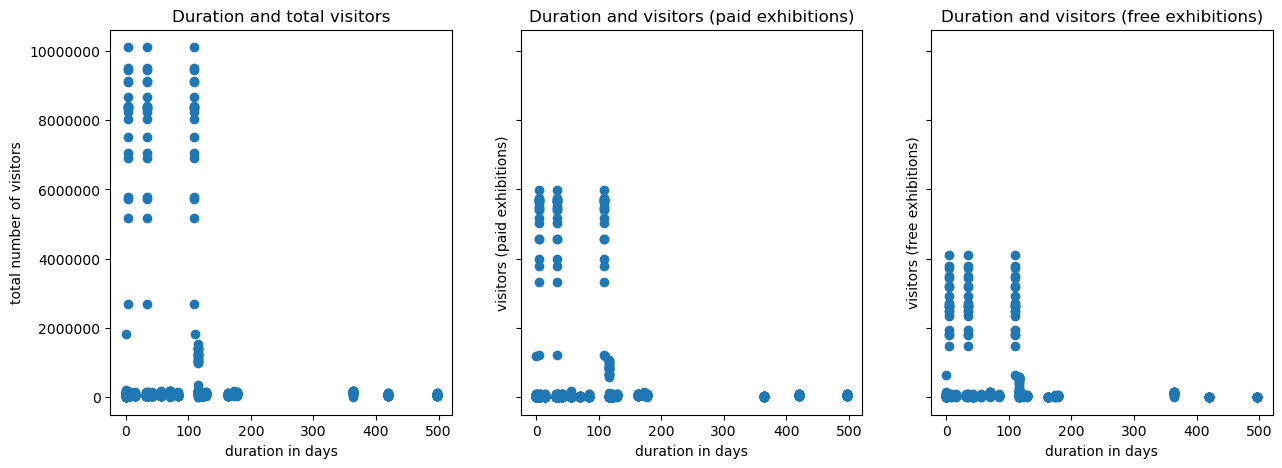

In [663]:
#plot correlation between duration and TOTAL / PAYANT / GRATUIT (number of visitors)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,5)) #use subplots to display the 3 graphs

ax1.set_title("Duration and total visitors")
ax1.set_xlabel("duration in days")
ax1.set_ylabel("total number of visitors")
ax1.scatter(df["durée"], df["TOTAL"])
ax1.set()

ax2.set(title="Duration and visitors (paid exhibitions)", xlabel="X", ylabel="Y")
ax2.set_xlabel("duration in days")
ax2.set_ylabel("visitors (paid exhibitions)")
ax2.scatter(df["durée"], df["PAYANT"])

ax3.set(title="Duration and visitors (free exhibitions)", xlabel="X", ylabel="Y")
ax3.set_xlabel("duration in days")
ax3.set_ylabel("visitors (free exhibitions)")
ax3.scatter(df["durée"], df["GRATUIT"])

plt.ticklabel_format(style='plain', axis='y') #avoid scientific notation for readibility purpose

plt.show()

We can see that points are widely scattered so the relationship between the duration and the number of visitors (TOTAL / PAYANT / GRATUIT) is weak.
Therefore, we can conclude that when the exhibitions duration (in days) increase, the number of visitors doesn't increase at the same time.
Let's have a look at the correlation matrix to confirm our hypothesis.

In [522]:
#compute the correlation matrix

data_matrix = df.corr()

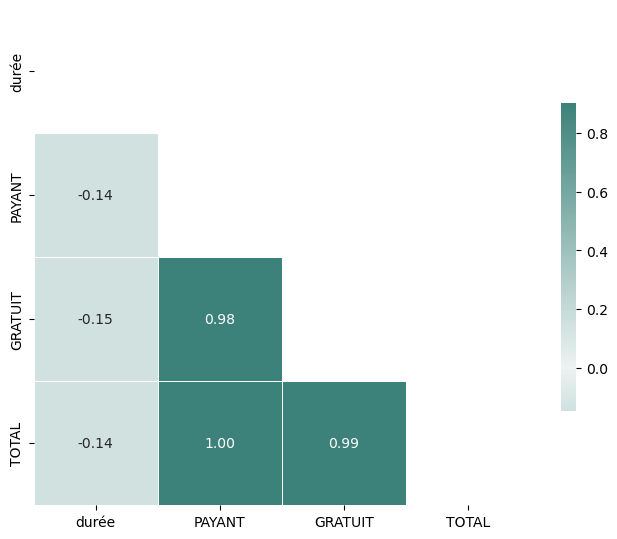

In [528]:
#plot the correlation matrix

mask=np.zeros_like(data_matrix, dtype=bool)
mask[np.triu_indices_from(mask)]= True

cmap=sns.diverging_palette(180, 180, as_cmap=True)

plt.figure(figsize=(8,8))
sns.plot = sns.heatmap(
    data_matrix, 
    mask=mask,
    cmap=cmap,
    vmax=.9,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5},
    annot=True, 
    fmt=".2f")

The correlation matrix allows us to see that there is a negative correlation between the number of visitors (TOTAL / PAYANT / GRATUIT). However, the negative correlation is very weak (negative but close to 0). In other words, it means that if the exhibitions duration (in days) increase, the number of visitors slightly decrease.

# Notes for myself

In [542]:
# Test = Paris_exhibitions_museums
# Test['Genre_1'] = Test['Mots clés'].str.split(",", expand=True)[0]
# Test['Genre_2'] = Test['Mots clés'].str.split(",", expand=True)[1]
# Test['Genre_3'] = Test['Mots clés'].str.split(",", expand=True)[2]

# Test = Test.melt(id_vars=['URL_x', 'Titre', 'Chapeau', 'Description', 'Date de début', 'Date de fin', 'Mots clés', 'Nom du lieu', 'Adresse du lieu', 'Code postal', 'Ville', 'Coordonnées géographiques', 'Type de prix', 'audience', 'Année', 'REGION', 'PAYANT', 'GRATUIT', 'TOTAL', 'NOMDEP', 'durée'], var_name="Genre")

# Test

# A APPLIQUER SUR Paris_exhibitions OU A APPLIQUER DANS TABLEAU

,URL_x,Titre,Chapeau,Description,Date de début,Date de fin,Mots clés,Nom du lieu,Adresse du lieu,Code postal,...,audience,Année,REGION,PAYANT,GRATUIT,TOTAL,NOMDEP,durée,Genre,value
0,https://www.paris.fr/evenements/nouveaute-baby...,Nouveauté ! Baby-visite au musée Bourdelle,Profitez d'une visite sensorielle et d'un temp...,<p>Une \nvisite sensorielle et participative a...,2023-05-10T13:30:00+02:00,2023-06-14T14:30:00+02:00,"Atelier,Enfants",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Public enfants adultes.,2019,ILE-DE-France,69186,92307,161493,PARIS,35,Genre_1,Atelier
1,https://www.paris.fr/evenements/nouveaute-baby...,Nouveauté ! Baby-visite au musée Bourdelle,Profitez d'une visite sensorielle et d'un temp...,<p>Une \nvisite sensorielle et participative a...,2023-05-10T13:30:00+02:00,2023-06-14T14:30:00+02:00,"Atelier,Enfants",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Public enfants adultes.,2020,ILE-DE-France,15977,34827,50804,PARIS,35,Genre_1,Atelier
2,https://www.paris.fr/evenements/mini-sculpteur...,Mini-sculpteur 1-3 ans en famille,Les tout-petits et leurs parents sont invités ...,<p>Après\n une découverte ludique du musée Bou...,2023-07-08T18:30:00+02:00,2023-09-03T14:00:00+02:00,"Atelier,Enfants,Loisirs",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Tout public. A partir de 1 ans.,2019,ILE-DE-France,69186,92307,161493,PARIS,56,Genre_1,Atelier
3,https://www.paris.fr/evenements/mini-sculpteur...,Mini-sculpteur 1-3 ans en famille,Les tout-petits et leurs parents sont invités ...,<p>Après\n une découverte ludique du musée Bou...,2023-07-08T18:30:00+02:00,2023-09-03T14:00:00+02:00,"Atelier,Enfants,Loisirs",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Tout public. A partir de 1 ans.,2020,ILE-DE-France,15977,34827,50804,PARIS,56,Genre_1,Atelier
4,https://www.paris.fr/evenements/atelier-de-mod...,Atelier de modelage en famille - Les étranges ...,Après une découverte joyeuse des jardins du mu...,<p>Après une découverte joyeuse des jardins du...,2023-07-26T19:00:00+02:00,2023-08-10T20:30:00+02:00,"Atelier,Enfants,Nature",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Tout public. A partir de 3 ans.,2019,ILE-DE-France,69186,92307,161493,PARIS,15,Genre_1,Atelier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,https://www.paris.fr/evenements/tu-te-souviend...,"« Tu te souviendras de moi », une expo-témoign...",L'exposition « Paroles et dessins des enfants ...,"<p>Située dans l’Ain, dans un cadre isolé et c...",2023-01-26T12:00:00+01:00,2023-07-23T22:00:00+02:00,"Expo,Histoire",Musée d'Art et d'Histoire du Judaïsme,"71, rue du Temple",75003,...,Public adolescents adultes.,2020,ILE-DE-France,19357,22828,42185,PARIS,178,Genre_3,None
170,https://www.paris.fr/evenements/stage-de-dessi...,Stage de dessin de morphologie : les muscles d...,Le dessin du corps humain requiert une connais...,<p>Le contenu du stage :</p><p>- Explication d...,2023-07-31T13:00:08+02:00,2023-08-04T19:30:08+02:00,Atelier,Musée du Louvre,"34, quai du Louvre",75001,...,Public adolescents adultes. A partir de 12 an...,2020,ILE-DE-France,1222612,1474972,2697584,PARIS,4,Genre_3,None
171,https://www.paris.fr/evenements/stage-de-dessi...,Stage de dessin de morphologie : les muscles d...,Le dessin du corps humain requiert une connais...,<p>Le contenu du stage :</p><p>- Explication d...,2023-07-31T13:00:08+02:00,2023-08-04T19:30:08+02:00,Atelier,Musée du Louvre,"34, quai du Louvre",75001,...,Public adolescents adultes. A partir de 12 an...,2019,ILE-DE-France,5729967,3790306,9520273,PARIS,4,Genre_3,None
172,https://www.paris.fr/evenements/rendez-vous-au...,Rendez-vous aux jardins - Frise végétale en ba...,"À l’occasion des Rendez-vous aux jardins, le m...",<p><strong>Frise végétale en bas-relief</stron...,2023-05-03T17:00:00+02:00,2023-06-04T21:00:00+02:00,"Atelier,Loisirs,Nature",Musée Bourdelle,"18, rue Antoine Bourdelle",75015,...,Tout public. A partir de 6 ans.,2019,ILE-DE-France

In [ ]:
# Revoir les audiences dans Tableau et en faire des bins ?

In [536]:
Paris_exhibitions['durée'].mean()

42.92332439678284

# NLP

In [498]:
# Example

# def evaluate_model(note, model, X_test, y_test, results):
#     pred = model.predict(X_test)
#     score = model.score(X_test, y_test)
#     precision = precision_score(y_test,pred)
#     recall = recall_score(y_test, pred)
#     f1 = f1_score(y_test, pred)
#     false_negatives = confusion_matrix(y_test, pred)[1][0]
#     new_result = pd.DataFrame({'note':note,'accuracy':score,'precision':precision,'recall':recall,'f1_score':f1,'false_negatives':false_negatives},index=[0])
#     return pd.concat([results,new_result],axis=0)